## Global modules import

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import numpy as np
import random as rnd
import sys
import torch

from sklearn.model_selection import train_test_split
from operator import itemgetter

## Local modules import

In [3]:
sys.path.append('..')

## Loading data

In [4]:
from data_loading import create_word_lists, tidy_sentence_length

In [5]:
with open('../data/corpus_data.json') as json_file:
    data = json.load(json_file)
data = data['records']

## Exploration

Calculate the proportion of badly transcribed german words such that STT transcript consists of multiple words:

In [6]:
num_words = 0
num_splits = 0

for entry in data:

    for word in entry["words"]:
        
        
        humw = word["human_word"]
        sttw = word["stt_word"]

        if "@g" in humw:
            num_words+=1

            if len(sttw.split()) > 1:
                num_splits += 1

print(num_splits, num_words, num_splits/num_words)

219 2251 0.09729009329187029


See baseline score when predicting only English:

In [17]:
import pandas as pd
from mlp import calc_stats
from data_loading import create_word_lists

In [23]:
_, _, word_labels, _, _ = create_word_lists(data)
stt_transcripts   = [entry['stt_transcript'] for entry in data]

In [20]:
len(stt_transcripts)

6723

In [25]:
word_labels2 = [int(l) for sublist in word_labels for l in sublist]

In [11]:
word_labels_t = torch.tensor(word_labels)
all_english = torch.zeros(len(word_labels))
accuracy, precision, recall, f1 = calc_stats(all_english, word_labels_t)
accuracy, precision, recall, f1

/home/dyco/EPFL/SEMESTAR_1/ML/ml-project-2-machinesoflearning/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.9700184575876736, 0.0, 0.0, 0.0)

In [54]:
import seaborn as sns
from matplotlib import pyplot as plt
plt.rcParams['text.usetex'] = True
plt.style.use('ggplot')

In [55]:
nb_words_per_record = np.array([len(sublist) for sublist in word_labels])

(0.0, 100.0)

<Figure size 640x480 with 0 Axes>

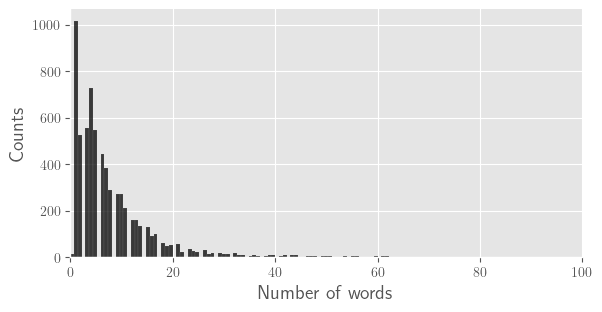

In [56]:
plt.figure()
sns.displot(nb_words_per_record, orientation='horizontal', height=3, aspect=2, color='k')
plt.xlabel("Number of words", size=14)
plt.ylabel("Counts", fontsize=14)
plt.xlim([0,100])

In [29]:
np.median(nb_words_per_record)

5.0

In [30]:
np.max(nb_words_per_record)

472

In [31]:
np.min(nb_words_per_record)

0

In [47]:
df = pd.read_csv('../outputs/BERT_BASE/bert_base_gs.csv')
normalized_df = df[['epochs','hidden_layers','neurons_per_layer','learning_rate']].copy()
normalized_df = (normalized_df - normalized_df.mean())/normalized_df.std()
normalized_df[['tr_loss','tr_loss_std','te_loss','te_loss_std']] = df[['tr_loss','tr_loss_std','te_loss','te_loss_std']].copy()

In [42]:
import statsmodels.formula.api as smf

In [50]:
mod = smf.ols(formula='te_loss ~ hidden_layers + neurons_per_layer + learning_rate', data=normalized_df)
res = mod.fit()

In [51]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                te_loss   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     5.162
Date:                Sun, 17 Dec 2023   Prob (F-statistic):            0.00192
Time:                        20:59:13   Log-Likelihood:                -587.37
No. Observations:                 180   AIC:                             1183.
Df Residuals:                     176   BIC:                             1196.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.8378      0.477      1.758      0.081      -0.103       1.778
hidden_layers         0.9511      0.478      1.990      0.048       0.008       1.894
neurons_per_layer     1.2060      0.478      2.523      0.013       0.263       2.149
learning_rate         1.0858      0.478      2.272      0.024       0.143       2.029
==============================================================================
Omnibus:                      325.749   Durbin-Watson:                   2.081
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            71568.652
Skew:                           9.149   Prob(JB):                         0.00
Kurtosis:                      98.957   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""